In [39]:
import madxmodule
import numpy as np
import pandas as pd

import time
s1 = time.time()
# setting bump amplitude
bumpamplist = [0.000]
npart = 50

basefilelist=[['lhcb1-twiss-emd.tfs']]
errorstringlist=['']
corrlist = np.array(['MCBCH.7R2.B1', 'MCBCH.9R2.B1', 'MCBH.13R2.B1'])

fileload='''
system,"ln -fns  /afs/cern.ch/eng/lhc/optics/HLLHCV1.2/ db5";
call, file="db5/hllhc.seq";
call, file="db5/opt_ions.madx";
on_alice := -1.0;
on_x2 := 1.0;
'''

# twiss file list
basetwissfilelist = [[madxmodule.Twiss('lhcb1',basefilelist[j][i],fileloading=fileload,targetxc=bumpamplist[j],IPcycle='IP2',targetel="MQ.11R2.B1",
                        correctorlist=corrlist,errorseq=errorstringlist[i],
                        twisscols=madxmodule.MADtwissColumns["LHCTwiss"],
                        beam=[madxmodule.MADX_Beam(1,seq='LHCB1',energy=82.*7000.),
                              madxmodule.MADX_Beam(2,seq='LHCB2',energy=82.*7000.)])
                    for i in range(len(basefilelist[j]))] for j in range(len(basefilelist))]


# initial parameters for BFPP
initialdictlist = [[madxmodule.get_initial(fn,madxmodule.dpPb(-1,0),location='IP2') for fn in basetwissfilelist[i]] 
                   for i in range(len(basetwissfilelist))]  

s2 = time.time()
print s2-s1

17.4807288647


In [16]:
initialdictlist

[[{'ALFX': -3.3245928289999998e-09,
   'ALFY': 5.3969821079999987e-10,
   'BETX': 0.49999999920000004,
   'BETY': 0.49999999939999995,
   'DELTAP': -0.005161845141702814,
   'PX': -2.9189966130000001e-07,
   'PY': 0.0001000006012,
   'X': -9.1679098949999996e-12,
   'Y': -1.033201698e-11}]]

In [19]:
fileextlist = [['noerr-0p0']]

transfermatrixfilelist = [
    [madxmodule.TransferMatrix('LHCB1','IP2','E.DS.R2.B1',initialdictlist[j][i],bumpamplist[j],"MQ.11R2.B1",
                               corrlist,fileloading=fileload,IPcycle='IP2',errorseq=errorstringlist[i],fileext=fileextlist[j][i],
                              beam=[madxmodule.MADX_Beam(1,seq='LHCB1',energy=82.*7000.),
                                    madxmodule.MADX_Beam(2,seq='LHCB2',energy=82.*7000.)]
                             ) for i in range(len(basetwissfilelist[j]))] for j in range(len(basefilelist))]

# writing transfermatrixfilelist to file for importing and plotting
dftransfermatrixfilelist       = [pd.DataFrame(pd.Series(data=transfermatrixfilelist[j]),columns=['filename']) 
                                  for j in range(len(transfermatrixfilelist))]

for j in range(len(dftransfermatrixfilelist)):
    dftransfermatrixfilelist[j].to_csv('transfermatrixfilenamelist'+ str(j) +'.csv',index=False)

opt         = madxmodule.io.tfsDict(basetwissfilelist[0][0])
prevelinex  = opt[0]["name"].index("LECL.11R2.B1")-1
s0          = opt[0]['s'][prevelinex]
print s0

419.3260424


In [20]:
# generating the filenames for storing the impactdistributions
impactfilelist    = [['impactIP2right_bp22_' + ext for ext in fileextlist[j]] for j in range(len(fileextlist))]
impactfilelistext = [[fn+'.csv' for fn in impactfilelist[j]] for j in range(len(impactfilelist))]

dfimpactfilelist  = [pd.DataFrame(pd.Series(data=impactfilelistext[j]),columns=['filename']) 
                     for j in range(len(impactfilelist))]

npart=50000
for j in range(len(transfermatrixfilelist)):
    for i in range(len(transfermatrixfilelist[j])):
        coordlist = madxmodule.TrackSigmaMatrix(transfermatrixfilelist[j][i],'LECL.11R2.B1',
                                                initialdictlist[j][i],npart)

MCS.B11R2.B1
DRIFT_56
LECL.11R2.B1


In [21]:
import csv
import scipy as sc
import collections
import glob
import subprocess
import datetime

from matplotlib import pyplot as plt
from matplotlib import rc, rcParams
from matplotlib.patches import Rectangle

from itertools import islice
from scipy import constants as const
df =pd.read_csv('lhcb1-twiss-emd.tfs',skiprows=range(47),delim_whitespace=True,names =madxmodule.MADtwissColumns["LHCTwiss"])

In [22]:
frontcollface = 3757.3775 # value provided by Cristina
s = frontcollface- (df[df['NAME']=='IP2']['S'].values- df[df['NAME']=='IP1']['S'].values \
+ df[df['NAME']=='LHCB1IP2_P_']['S'].values)-s0
 
distr = [np.dot(madxmodule.Mdrift6D(s),coordlist[i]) for i in range(len(coordlist))]

In [23]:
deltam = -const.neutron_mass * const.c**2/const.value('electron volt-joule relationship')/10**9
p0 =  madxmodule.get_p(transfermatrixfilelist[0][0])
mass = madxmodule.ionmass
delta = madxmodule.dpPb(-1,0)

distr = np.array(distr)
xcol  = pd.Series(data=distr[:,0])*1000
pxcol = pd.Series(data=distr[:,1])
ycol  = pd.Series(data=distr[:,2])
pycol = pd.Series(data=distr[:,3])
tcol  = pd.Series(data=distr[:,4])
ptcol = pd.Series(data=distr[:,5])
# Ecol  = pd.Series(data=
#                       np.sqrt((mass + deltam)**2 + (p0 * (1 + distr[:,5] - delta) * \
#                                                                (1 + deltam/mass))**2)) 

outdf             = pd.DataFrame(xcol,columns=['x[mm]'])
outdf['px[1e-3]'] = pd.Series(data=pxcol)*1000
outdf['y[mm]']    = pd.Series(data=ycol)*1000
outdf['py[1e-3]'] = pd.Series(data=pycol)*1000
outdf['t']        = pd.Series(data=tcol)# *1.e-9*const.c
outdf['pt']       = pd.Series(data=ptcol) 
outdf.to_csv('emdat3757p3775' + '.csv',index=False)
outdf['x[mm]'].hist(bins=100)
plt.show()

# Plotting to see the EMD beam

In [24]:
plt.hist(coordlist[:,4],bins=50)
plt.show()

# Checking the tfs files and plotting to see trajectory EMD

In [17]:
import pandas as pd
df =pd.read_csv('lhcb1-twiss-emd.tfs',skiprows=range(47),delim_whitespace=True,names =madxmodule.MADtwissColumns["RMatrixExtended"])

In [25]:
df2 = pd.read_csv(transfermatrixfilelist[0][0],skiprows=range(47),delim_whitespace=True,names =madxmodule.MADtwissColumns["RMatrixExtended"])

In [26]:

df2.plot(x='S',y='X')
df2.plot(x='S',y='Y',color='red')
plt.show()

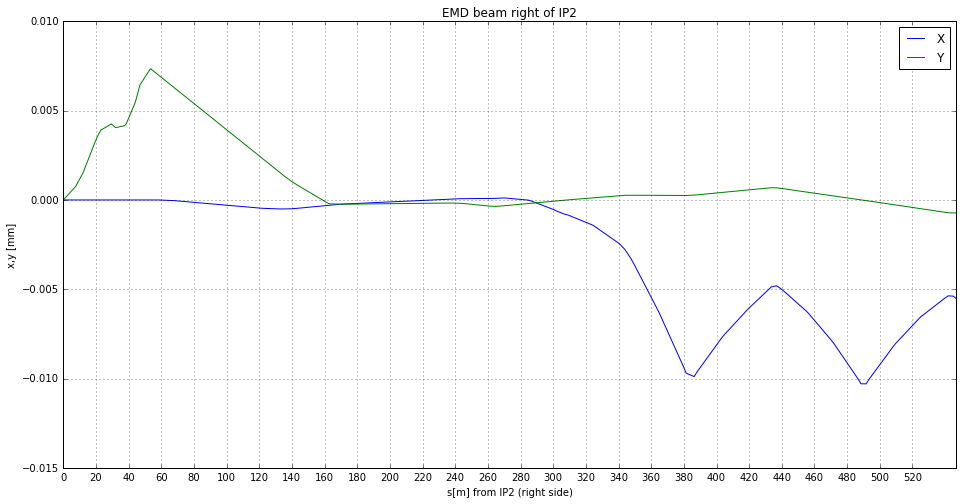

In [29]:
%matplotlib inline
df3 = df2.set_index('S')[['X','Y']]
df3.plot(figsize=(16,8),grid=True,xticks=range(0,540,20))
plt.xlabel('s[m] from IP2 (right side)')
plt.ylabel('x,y [mm]')
plt.title('EMD beam right of IP2')
plt.savefig('EMD_IP2_right.png',format='png')
plt.show()

In [19]:
df[df['NAME']=='IP2']

,NAME,KEYWORD,PARENT,S,L,X,PX,Y,PY,T,...,RE53,RE54,RE55,RE56,RE61,RE62,RE63,RE64,RE65,RE66
0,IP2,MARKER,OMK,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0aa0ef5f10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f0aa0647290>]], dtype=object)

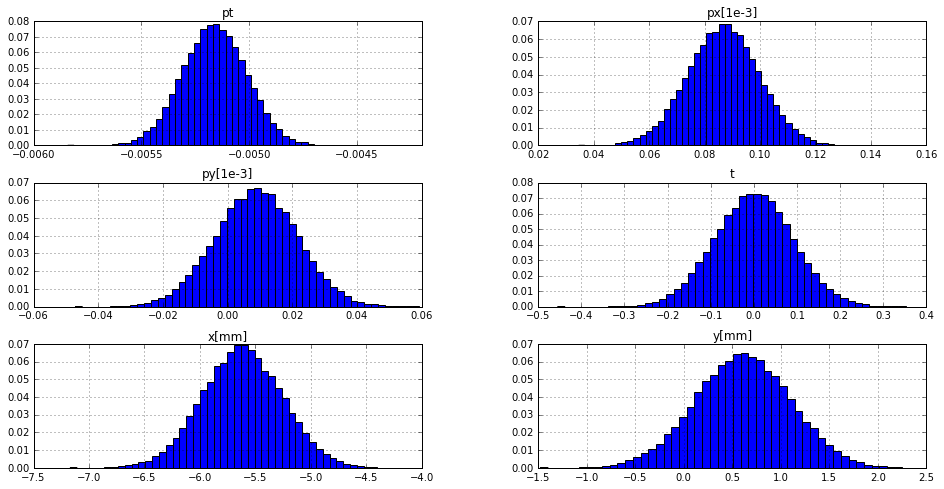

In [38]:
outdf.hist(figsize=(16,8), bins=50,weights=[1/float(npart) for i in range(len(outdf))])